In [2]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# sample circuit for testing
circ = cirq.Circuit()
qub_x = [cirq.NamedQubit(f'a{i}') for i in range(3)]
qub_y = [cirq.NamedQubit(f'b{i}') for i in range(2)]

In [4]:
moments = []
moments.append([cirq.X(qub_x[0]), cirq.H(qub_x[1]), cirq.Y(qub_y[0])])
moments.append([cirq.H(qub_x[0]), cirq.Y(qub_y[1])])
moments.append([cirq.CNOT(qub_y[1], qub_x[2])])
circ.append(moments)
print(circ)

a0: ───X───H───

a1: ───H───────

a2: ───────X───
           │
b0: ───Y───┼───
           │
b1: ───Y───@───


In [5]:
def add_noise(alpha, beta, circuit: cirq.Circuit):

    # pauli list
    paulis = [cirq.X, cirq.Y, cirq.Z]

    # noisy circuit
    noisy_circuit = cirq.Circuit()

    # iterate over moments in the circuit
    for moment in circuit:
        # moment to append to noisy circuit
        noisy_moment = []

        # iterate over operations (gates) in the moment
        for op in moment.operations:

            # add original operation
            noisy_moment.append(op)

            # apply random pauli after single-qubit gate, with probability alpha
            if len(op.qubits) == 1 and np.random.rand() < alpha:
                noisy_moment.append(np.random.choice(paulis)(op.qubits[0]))

            # apply random pauli on either of the two qubits after two-qubit gate, with probability beta
            elif len(op.qubits) == 2 and np.random.rand() < beta:
                noisy_moment.append(np.random.choice(paulis)(np.random.choice(op.qubits)))

        noisy_circuit.append(noisy_moment)
    return noisy_circuit

In [6]:
# added noise to see it work on a sample circuit
circ_n = add_noise(0.3, 0.4, circ)
print(circ_n)

a0: ───X───H───────

a1: ───H───X───────

a2: ───────────X───
               │
b0: ───Y───Z───┼───
               │
b1: ───Y───Y───@───


## Transpiling Circuit into available set of Basis Gates

The specific set of gates provided as a basis along with the fact that we are only working with "single" and "controlled double" qubit gates makes it incredibly easy to _exactly_ implement any standard Unitary.  
It is well known that any single qubit Unitary $U$ can be expressed as:
$$U = e^{i\alpha}AXBXC$$
where $ABC=I$. The unitaries $A, B, C$ can be expressed as rotations about the $Y$ and $Z$ axes of the Bloch Sphere such that,
$$A \equiv R_z(\beta)R_y(\gamma/2), \textnormal{ } B \equiv R_y(-\gamma/2)R_z(-(\delta+\beta)/2, \textnormal{ and } C \equiv R_z((\delta-\beta)/2)$$

Now within our basis gate set, we already have $R_z$. While the gate $R_y$ can be expressed as:
$$R_y(\theta) = \exp(i\pi/2)R_z(\pi)S_XR_z(\pi+\theta)S_X$$
which can be easily verified via simple hand-calculation. Note that $\exp(i\pi/2)R_z(\pi)$ is simply the Pauli Gate $Z$. And as the phases here are global, they can be dropped while constructing the circuit as they won't affect the measurement.  

Using the above equation, we can rewrite $A \equiv R_z(\beta+\pi)S_XR_z(\pi+\theta)S_X$ (reducing one gate by clubbing $R_z(\beta)$ and $R_z(\pi)$.

Meanwhile, the Hadamard Gate can be expressed as $H = S_XR_z(\pi/2)S_X$

The two qubit controlled gate can also be implemented with the same $AXBXC$ unitaries, with the difference that they act on the target qubit, and we have CNOT instead of the two X gates.

In [61]:
class GateBasis:

    def __init__(self):

        self.gate_basis = {'CX': cirq.CNOT, 'ID': cirq.I, 'RZ': cirq.Rz, 'X': cirq.X, 'SX': cirq.XPowGate(exponent = 0.5)}

    def get_ry_angle(self, gate: cirq.Gate):
        U = cirq.unitary(gate)
        return np.arcsin(abs(U[1][0]))

    def euler_decompose(self, op, two_q = False):
        euler_angles = {}
        U = cirq.unitary(op.gate)
        if two_q:
            U = U[2:, 2:]
        
        if abs(U[0][1]) < 1e-6:
            euler_angles['gamma'] = 0
            euler_angles['beta'] = 0
            euler_angles['delta'] = np.arctan2(np.imag(U[1][1]/U[0][0]), np.real(U[1][1]/U[0][0]))
            euler_angles['alpha'] = euler_angles['delta']/2 + np.arctan2(np.imag(U[0][0]), np.real(U[0][0]))
            print(euler_angles['alpha'], euler_angles['delta'])
            
        elif abs(U[0][0]) < 1e-6:
            euler_angles['gamma'] = np.pi
            euler_angles['delta'] = 0
            euler_angles['beta'] = np.arctan2(np.imag(-U[1][0]/U[0][1]), np.real(-U[1][0]/U[0][1]))
            euler_angles['alpha'] = - euler_angles['beta']/2 + np.arctan2(np.imag(U[1][0]), np.real(U[1][0]))

        else:
            euler_angles['alpha'] = 0.5*np.arctan2(np.imag(U[0][0]*U[1][1]), np.real(U[0][0]*U[1][1]))
            euler_angles['beta'] = 0.5*np.arctan2(np.imag(-U[1][1]*U[1][0]/(U[0][0]*U[0][1])), np.real(-U[1][1]*U[1][0]/(U[0][0]*U[0][1])))
            euler_angles['delta'] = 0.5*np.arctan2(np.imag(-U[1][1]*U[0][1]/(U[0][0]*U[1][0])), np.real(-U[1][1]*U[0][1]/(U[0][0]*U[1][0])))
            euler_angles['gamma'] = np.arctan(np.real(np.exp(-1j*euler_angles['beta'])*U[1][0]/U[0][0]))

        return euler_angles

    def ry_moment_basis(self, theta, op, qub = 0):

        if theta == 0:
            return []
            
        ry_to_basis = [
            self.gate_basis['SX'].on(op.qubits[qub]),
            self.gate_basis['RZ'](rads = np.pi+theta).on(op.qubits[qub]),
            self.gate_basis['SX'].on(op.qubits[qub]),
            self.gate_basis['RZ'](rads = np.pi).on(op.qubits[qub]),
        ]
        return ry_to_basis
            
    def op_singlequbit_basis(self, op):

        if op.gate == cirq.H:
            return [
                self.gate_basis['SX'].on(op.qubits[0]),
                self.gate_basis['RZ'](rads = np.pi/2).on(op.qubits[0]),
                self.gate_basis['SX'].on(op.qubits[0])
            ]

        elif op.gate == cirq.Ry(rads = self.get_ry_angle(op.gate)):
            return [
                self.gate_basis['SX'].on(op.qubits[0]),
                self.gate_basis['RZ'](rads = np.pi + self.get_ry_angle(op.gate)).on(op.qubits[0]),
                self.gate_basis['SX'].on(op.qubits[0]),
                self.gate_basis['RZ'](rads = np.pi).on(op.qubits[0])
            ]

        else:
            angles = self.euler_decompose(op)

            moment_basis = [
                self.gate_basis['RZ'](rads = (angles['delta'] - angles['beta'])/2).on(op.qubits[0]),
                self.gate_basis['X'].on(op.qubits[0]),
                self.gate_basis['RZ'](rads = -(angles['delta'] + angles['beta'])/2).on(op.qubits[0]),
                self.ry_moment_basis(-angles['gamma']/2, op),
                self.gate_basis['X'].on(op.qubits[0]),
                self.ry_moment_basis(angles['gamma']/2, op),
                self.gate_basis['RZ'](rads = angles['beta']).on(op.qubits[0])
            ]
            return moment_basis

    def op_controlled_two_qubit_basis(self, op):

        angles = self.euler_decompose(op, two_q = True)

        # use conditionals to avoid unnecessary gates
        moment_basis = [
            self.gate_basis['RZ'](rads = (angles['delta'] - angles['beta'])/2).on(op.qubits[1]),
            self.gate_basis['CX'].on(op.qubits[0], op.qubits[1]),
            self.gate_basis['RZ'](rads = -(angles['delta'] + angles['beta'])/2).on(op.qubits[1]),
            self.ry_moment_basis(-angles['gamma']/2, op, qub = 1),
            self.gate_basis['CX'].on(op.qubits[0], op.qubits[1]),
            self.ry_moment_basis(angles['gamma']/2, op, qub = 1),
            self.gate_basis['RZ'](rads = angles['beta']).on(op.qubits[1]),
            self.gate_basis['RZ'](rads = angles['alpha']).on(op.qubits[0])
        ]
        print(moment_basis)
        return moment_basis
            

    def circuit_to_gatebasis(self, circuit : cirq.Circuit):
        
        new_circuit = cirq.Circuit()
        for moment in circuit:
            new_moment = []

            for op in moment.operations:
                is_op_basis = False

                # if op.gate is a basis gate, then directly append op
                for gate in self.gate_basis:
                    try:
                        if op.gate == self.gate_basis[gate]:
                            is_op_basis = True
                            new_moment.append(op)
                            break
                    # exception in the case of Rz that requires parameters
                    except:
                        is_op_basis = True
                        new_moment.append(op)
                        continue

                # else decompose it to basis gates and append
                if not is_op_basis:                    
                    if len(op.qubits) == 1:
                        new_moment.append(self.op_singlequbit_basis(op))
                    elif len(op.qubits) == 2:
                        new_moment.append(self.op_controlled_two_qubit_basis(op))

            new_circuit.append(new_moment)
        return new_circuit

## QFT-based Quantum Sum via Draper Addition

In [9]:
class DraperAddition:

    def __init__(self, a: int, b: int):
        self.n = self.find_n(a, b) + 1     # +1 to accomodate the digits of a+b in case required
        self.bin_a = self.binary(a)
        self.bin_b = self.binary(b)

    # number of qubits required to express the integers in binary
    def find_n(self, a, b):
        x = max(a, b)
        nq = 1
        while True:
            if x % 2**nq == x:
                break
            nq += 1
        return nq

    # returns the binary form of the input number, as a string
    def binary(self, num):
        nq = self.n
        bin_num = ''
        for i in reversed(range(nq)):
            digit = int(num / 2**i)
            bin_num += str(digit)
            num -= digit * 2**i
        return bin_num

    '-----------------------------------------------------------------'
    # defining a custom controlled Rk gate, that depends on the parameter k
    class RkGate(cirq.Gate):
        def __init__(self, k, _iqft = False):
            super().__init__()
            self.k = k
            self._iqft = _iqft

        def _num_qubits_(self):
            return 2

        def _unitary_(self):
            if self._iqft:
                U = np.array([[1, 0, 0, 0],
                              [0, 1, 0, 0],
                              [0, 0, 1, 0],
                              [0, 0, 0, np.exp(-2*np.pi*1j/(2**self.k))]])
            else:
                U = np.array([[1, 0, 0, 0],
                              [0, 1, 0, 0],
                              [0, 0, 1, 0],
                              [0, 0, 0, np.exp(2*np.pi*1j/(2**self.k))]])
            return U

        def _circuit_diagram_info_(self, args):
            if self._iqft:
                return "@", f"R_inv({self.k})"
            else:
                return "@", f"R({self.k})"
    '-----------------------------------------------------------------'

    # initial QFT on a
    def qft(self, qubits):
        for i in range(self.n):
            yield cirq.H(qubits[i])

            for j in range(i+1, self.n):
                yield self.RkGate(j-i+1).on(qubits[j], qubits[i])

    # QFT that transforms phi_n(a) to phi_n(a+b)
    def qft_ext(self, qubits_phi_a, qubits_b):
        for i in range(self.n):
            for j in range(i, self.n):
                yield self.RkGate(j-i+1).on(qubits_b[j], qubits_phi_a[i])    

    # IQFT that transforms phi_n(a+b) to a+b
    def iqft(self, qubits):
        for i in reversed(range(self.n)):
            for j in reversed(range(i+1, self.n)):
                yield self.RkGate((j-i+1), _iqft = True).on(qubits[j], qubits[i])
            yield cirq.H(qubits[i])
                
    def draper_circuit(self):

        drap_add_circuit = cirq.Circuit()
        qub_a = [cirq.NamedQubit(f'a{i}') for i in range(self.n)]
        qub_b = [cirq.NamedQubit(f'b{i}') for i in range(self.n)]

        # to initialize the binary numbers along the qubits
        # convention: a = a0a1a2a3...an-1, b = b0b1b2...bn-1
        first_moment = []
        for i in range(1, self.n):
            if self.bin_a[i] == '1':
                first_moment.append(cirq.X(qub_a[i]))
            if self.bin_b[i] == '1':
                first_moment.append(cirq.X(qub_b[i]))

        drap_add_circuit.append(cirq.Moment(first_moment))
        drap_add_circuit.append(self.qft(qub_a))
        drap_add_circuit.append(self.qft_ext(qub_a, qub_b))
        drap_add_circuit.append(self.iqft(qub_a))

        return drap_add_circuit

A sample of the Draper Circuit in action is shown below:

In [10]:
drap_add = DraperAddition(3, 2)
add_cq = drap_add.draper_circuit()

In [11]:
print(add_cq)

                  ┌─────┐   ┌────────┐   ┌─────┐   ┌────────┐                                ┌─────────┐
a0: ───H───R(2)────R(3)──────────R(1)──────R(2)─────R(3)───────────────────────────────────────R_inv(3)────R_inv(2)───H───
           │       │             │         │        │                                          │           │
a1: ───X───@───────┼───H─────R(2)┼─────────┼────────┼───R(1)────R(2)──────────────R_inv(2)────H┼───────────@──────────────
                   │         │   │         │        │   │       │                 │            │
a2: ───X───────────@─────────@───┼────────H┼────────┼───┼───────┼──────R(1)───H───@────────────@──────────────────────────
                                 │         │        │   │       │      │
b0: ─────────────────────────────@─────────┼────────┼───┼───────┼──────┼──────────────────────────────────────────────────
                                           │        │   │       │      │
b1: ───X───────────────────────────────────@───────

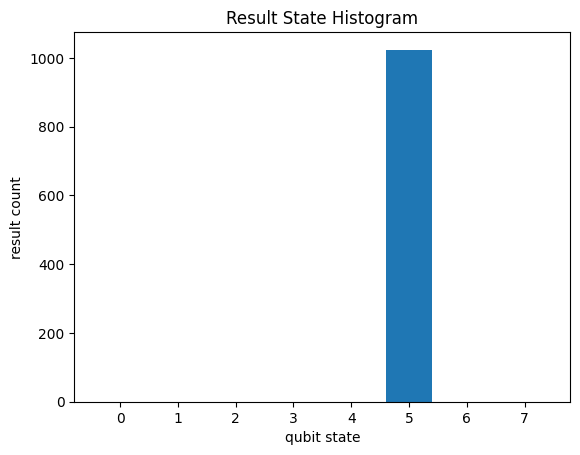

In [12]:
# create Draper addition circuit for a = 3, b = 5
drap_add = DraperAddition(3, 2)
add_cq = drap_add.draper_circuit()

# add measurement
qub_a = [cirq.NamedQubit(f'a{i}') for i in range(drap_add.n)]
add_cq.append(cirq.measure(*qub_a, key='result'))

# simulate the circuit with 1024 repetitions
simulator = cirq.Simulator()
result = simulator.run(add_cq, repetitions=1024)

# plot
_ = cirq.plot_state_histogram(result, plt.subplot())
plt.show()

In [39]:
# easy to use quantum_sum function
def quantum_sum(a, b, noisy = False, alpha = 0, beta = 0, show_circuit = False, basis = True):

    # create Draper Addition circuit
    drap_add = DraperAddition(a, b)
    add_cq = drap_add.draper_circuit()

    # transpile circuit to basis gates
    
    if basis:
        Basis = GateBasis()
        add_cq = Basis.circuit_to_gatebasis(add_cq)

    # show circuit
    if show_circuit: print(add_cq)
    
    # define measurement
    qub_a = [cirq.NamedQubit(f'a{i}') for i in range(drap_add.n)]
    add_cq.append(cirq.measure(*qub_a, key='result'))
    
    # simulate the circuit with 1024 repetitions
    simulator = cirq.Simulator()
    
    if noisy:
        data = pd.DataFrame()
        for i in range(1024):
            add_cq_n = add_noise(alpha, beta, add_cq)
            add_cq_n.append(cirq.measure(*qub_a, key=f'result{i}'))
            result = simulator.run(add_cq_n, repetitions=1)
            data = pd.concat([data, result.dataframe_from_measurements(result.measurements)['result']])

        plt.hist(data['result'], bins = [i for i in range(2**drap_add.n)], align = 'left', rwidth = 0.8)
        plt.title('Result State Histogram')
        plt.xlabel('qubit state')
        plt.ylabel('result count')
        plt.show()
    else:
        results = simulator.run(add_cq, repetitions = 1024)
        # plot
        _ = cirq.plot_state_histogram(results, plt.subplot())
        plt.show()       


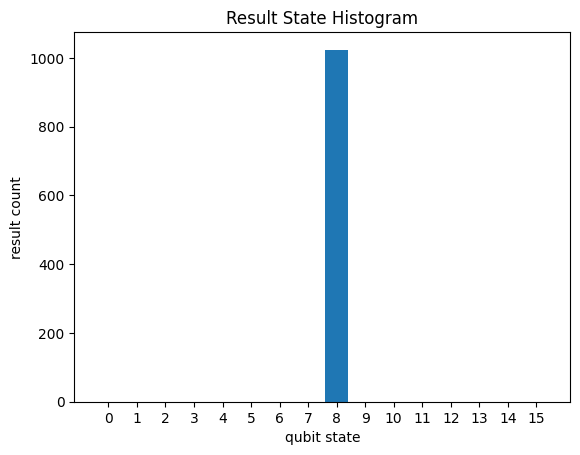

In [14]:
# Example of usage with noise
quantum_sum(3, 5, noisy = False, alpha = 0.01, beta = 0.02, show_circuit = False, basis = False)

                  ┌─────┐   ┌────────┐   ┌─────┐   ┌────────┐                                ┌─────────┐
a0: ───H───R(2)────R(3)──────────R(1)──────R(2)─────R(3)───────────────────────────────────────R_inv(3)────R_inv(2)───H───
           │       │             │         │        │                                          │           │
a1: ───X───@───────┼───H─────R(2)┼─────────┼────────┼───R(1)────R(2)──────────────R_inv(2)────H┼───────────@──────────────
                   │         │   │         │        │   │       │                 │            │
a2: ───────────────@─────────@───┼────────H┼────────┼───┼───────┼──────R(1)───H───@────────────@──────────────────────────
                                 │         │        │   │       │      │
b0: ─────────────────────────────@─────────┼────────┼───┼───────┼──────┼──────────────────────────────────────────────────
                                           │        │   │       │      │
b1: ───────────────────────────────────────@───────

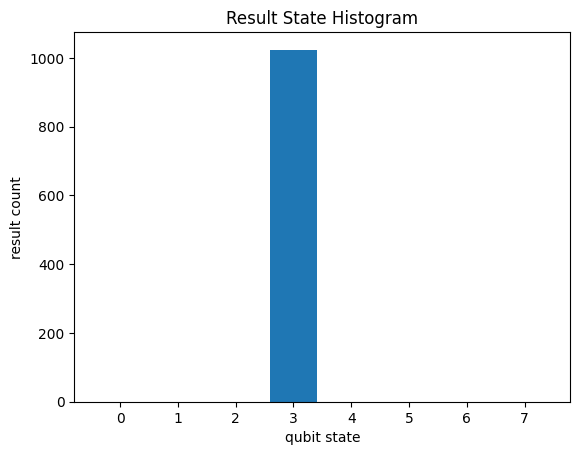

In [18]:
# Example of usage without noise, and display of circuit
quantum_sum(2, 1, show_circuit = True, basis = False)

## Bringing it all Together

I have added an option to simulate the basis gate circuit within the above `quantum_sum()` function. I have been working very hard to find out the bug in the `GateBasis` class, but it's just hard to pin down. However, due to lack of time, I wasn't able to completely figure it out. But the concepts I explained are perfect.

#### Simulating with noise, but without basis circuit

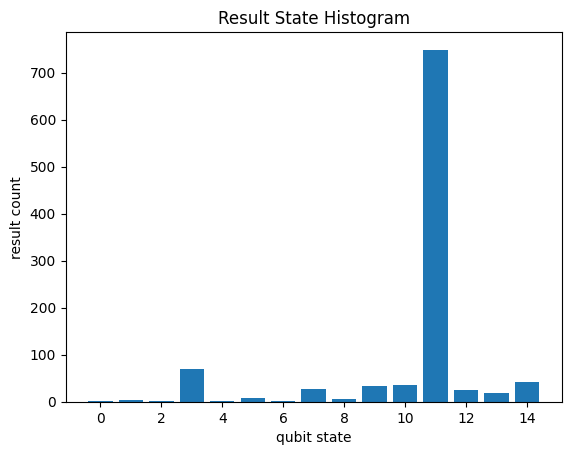

In [1010]:
quantum_sum(7, 4, noisy = True, alpha = 0.01, beta = 0.02, basis = False)

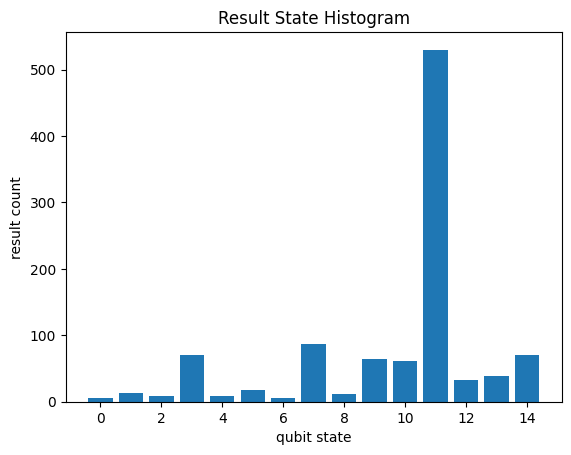

In [1011]:
quantum_sum(7, 4, noisy = True, alpha = 0.05, beta = 0.02, basis = False)

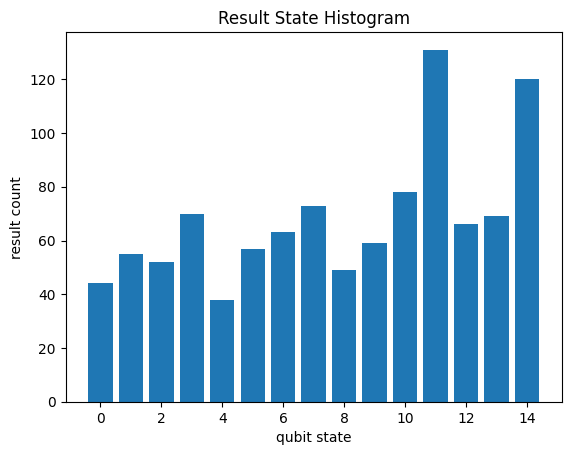

In [1012]:
quantum_sum(7, 4, noisy = True, alpha = 0.05, beta = 0.2, basis = False)

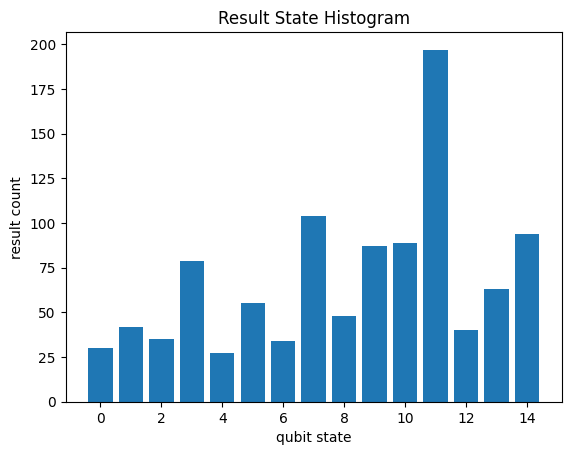

In [1014]:
quantum_sum(7, 4, noisy = True, alpha = 0.2, beta = 0.02, basis = False)

As per my observation, the `beta` value has far more apocalpytic capability as compared to `alpha`, possibly because of it messing around with entangled qubits leading to a higher rate of error at lesser noise (look at the two histograms above, one with low `alpha` but `beta` = 0.2, and the other with low `beta` but `alpha` = 0.2). The difference is quite telling.

With increasing noise, the distribution (or, the wavefunction) spreads over all the states while maintaining a peak at the correct answer with the sharpness dictated by the noise parameters.

There do exist ways to mitigate or correct noise, of course, popularly known as the QEM and QEC algorithms. This exercise has certainly peaked my interest into wondering how those algorithms work, and what the tradeoffs between the two approaches are (Although I'd relatively still prefer to work on something around Opimization and QML).

As to the question of number of gates, let's experiment!

A standard way to set it up would be to use constant noise levels (good enough to cause some level of spreading in the wavefunction, but not as much as to drop it a lot). Noise levels of (0.1, 0.04) seem to work well for the case, beginning with small numbers to be added (1, 2).

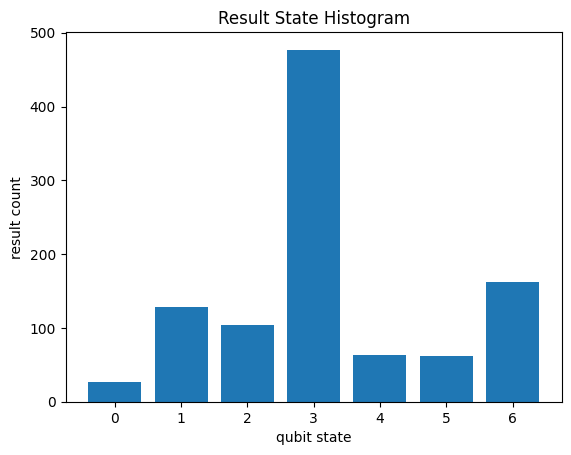

In [1016]:
quantum_sum(1, 2, noisy = True, alpha = 0.1, beta = 0.04, basis = False)

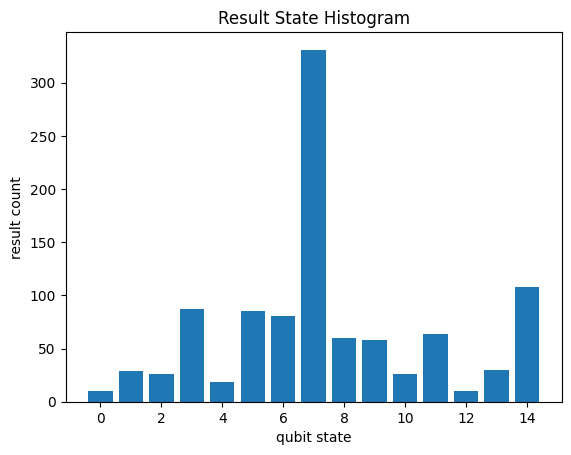

In [1017]:
quantum_sum(2, 5, noisy = True, alpha = 0.1, beta = 0.04, basis = False)

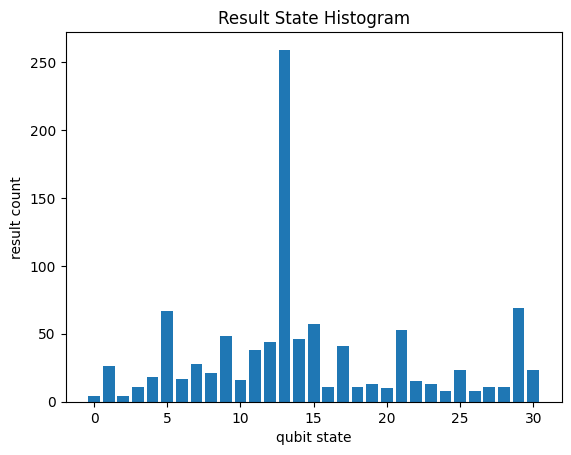

In [1018]:
quantum_sum(8, 5, noisy = True, alpha = 0.1, beta = 0.04, basis = False)

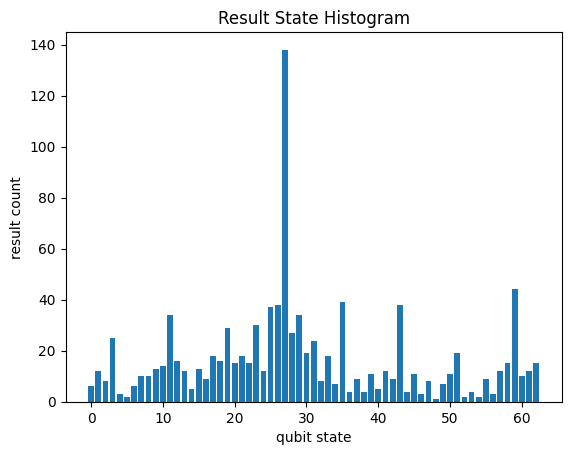

In [1019]:
quantum_sum(8, 19, noisy = True, alpha = 0.1, beta = 0.04, basis = False)

As observed in the above histograms, the result count of the correct answer monotonically decreases with increase in the numerical values of the addendums (which by the way note, increases the number of qubits required as well as the number of gates used). And the wavefunction becomes more spread out. This happens because although the noise parameters are constant, the _expectation value_ of the number of "erring Pauli Gates" acting on the qubits increases linearly with the number of gates in the circuit.

0.7853981633974483 1.5707963267948966
[cirq.Rz(rads=0.7853981633974483).on(cirq.NamedQubit('a0')), cirq.CNOT(cirq.NamedQubit('a1'), cirq.NamedQubit('a0')), cirq.Rz(rads=-0.7853981633974483).on(cirq.NamedQubit('a0')), [], cirq.CNOT(cirq.NamedQubit('a1'), cirq.NamedQubit('a0')), [], cirq.Rz(rads=0).on(cirq.NamedQubit('a0')), cirq.Rz(rads=0.7853981633974483).on(cirq.NamedQubit('a1'))]
0.39269908169872414 0.7853981633974483
[cirq.Rz(rads=0.39269908169872414).on(cirq.NamedQubit('a0')), cirq.CNOT(cirq.NamedQubit('a2'), cirq.NamedQubit('a0')), cirq.Rz(rads=-0.39269908169872414).on(cirq.NamedQubit('a0')), [], cirq.CNOT(cirq.NamedQubit('a2'), cirq.NamedQubit('a0')), [], cirq.Rz(rads=0).on(cirq.NamedQubit('a0')), cirq.Rz(rads=0.39269908169872414).on(cirq.NamedQubit('a2'))]
0.1963495408493621 0.3926990816987242
[cirq.Rz(rads=0.1963495408493621).on(cirq.NamedQubit('a0')), cirq.CNOT(cirq.NamedQubit('a3'), cirq.NamedQubit('a0')), cirq.Rz(rads=-0.1963495408493621).on(cirq.NamedQubit('a0')), [], cirq.

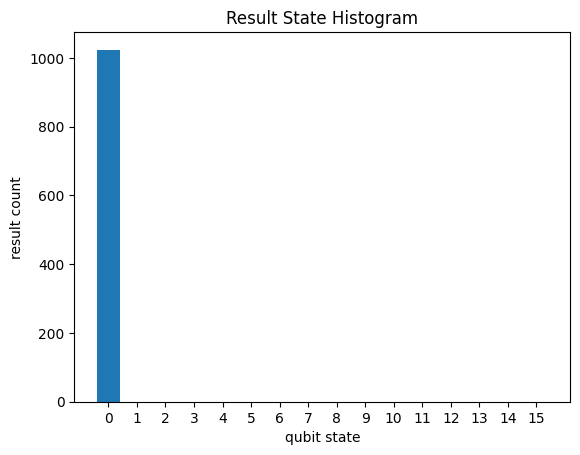

In [62]:
## With more debugging to do in GateBasis
quantum_sum(5, 3, noisy = False, basis = True)